<a href="https://colab.research.google.com/github/avyasharma/Skunkworks-iForests/blob/main/RF_distv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from sklearn.ensemble import RandomForestRegressor,IsolationForest
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

In [17]:
def read_csv(path):
    df = pd.read_csv(path)
    return df

In [18]:
train= read_csv('friedman_data_500.csv')
train_x = train.loc[:,'x0':'x4']
train_y = train.loc[:,'y']
trainX = train_x.values.tolist()
trainY = train_y.values.tolist()

In [19]:
# test
test = read_csv('friedman_data_1000.csv')
test_x = test.loc[:,'x0':'x4']
test_y = test.loc[:,'y']
testX = test_x.values.tolist()
testY = test_y.values.tolist()

In [20]:
numTree = 500
clf = RandomForestRegressor( n_estimators= numTree, max_depth = 30)
clf.fit(trainX,trainY)

IF = IsolationForest(n_estimators=numTree, contamination = 'auto')
IF.fit(trainX)


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=500,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [21]:
# predict RFR
predicty = []
sd_list = []
for i in range(len(testX)):
    all_p = []
    for tree in range(numTree):
        p = clf.estimators_[tree].predict([testX[i]])
        all_p.append(p)
    sd = np.std(all_p)
    predicty.append( sum(all_p)/len(all_p) )
    sd_list.append(sd)

sd_series = pd.Series(sd_list)
predy_series = pd.Series(predicty)
residual = (test_y - predy_series) / pd.Series(predy_series)

In [22]:
# predict IF

IF_pred = IF.predict(testX)
IF_pred = pd.DataFrame(IF_pred)
IF_pred = IF_pred.values
decision_score = IF.decision_function(testX)


In [23]:
# find average of each x variable

x0 = train.loc[:, 'x0']
avg_x0 =  sum(x0) / len(x0)
x1 = train.loc[:, 'x1']
avg_x1 =  sum(x1) / len(x1)
x2 = train.loc[:, 'x2']
avg_x2 =  sum(x2) / len(x2)
x3 = train.loc[:, 'x3']
avg_x3 =  sum(x3) / len(x3)
x4 = train.loc[:, 'x4']
avg_x4 =  sum(x4) / len(x4)
avg_x = np.array([avg_x0, avg_x1, avg_x2, avg_x3, avg_x4])

distance = []
size = 1000
#find L2 Norm error for each sample. 
for i in range(size):
    a = avg_x
    b = np.array(test_x.iloc[i])
    dist = np.linalg.norm(a-b)
    distance.append(dist)

## residual - predErr.  vs. distance
### predErr is SD of predicted y on test data x
### 500 training data, 1000 testing data.

Text(0, 0.5, 'residual - SD')

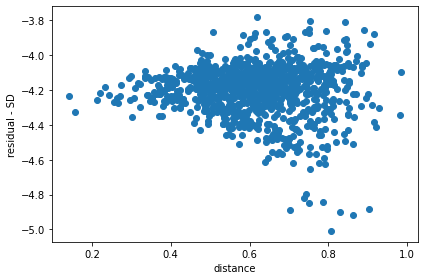

In [24]:
res_predErr = residual - np.std(predy_series)
_, axs = plt.subplots( tight_layout=True)
axs.scatter(distance, res_predErr)
axs.set_xlabel('distance')
axs.set_ylabel('residual - SD')

## (Residual – predErr’ ) vs distance 
### SD of ensemble of prediction

Text(0, 0.5, 'residual - SD')

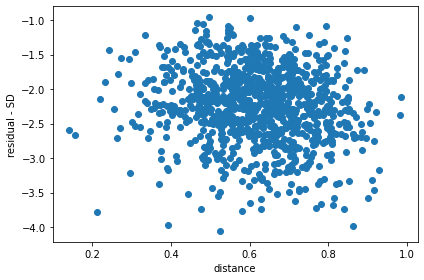

In [25]:
res_predErr = residual - sd_series
_, axs = plt.subplots( tight_layout=True)
axs.scatter(distance, res_predErr)
axs.set_xlabel('distance')
axs.set_ylabel('residual - SD')

## Residual vs. distance

Text(0, 0.5, 'residual')

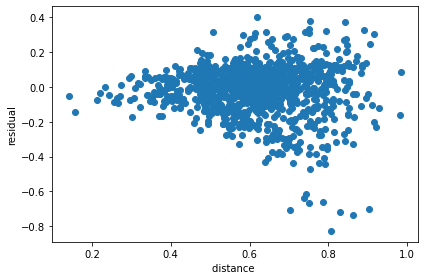

In [26]:
_, axs = plt.subplots( tight_layout=True)
axs.scatter(distance, residual)
axs.set_xlabel('distance ')
axs.set_ylabel('residual')

## predErr vs distance
### predErr: SD of ensemble of prediction

Text(0, 0.5, 'SD of ensemble of prediction')

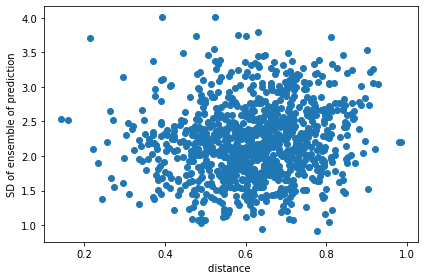

In [27]:
_, axs = plt.subplots( tight_layout=True)
axs.scatter(distance, sd_series)
axs.set_xlabel('distance ')
axs.set_ylabel('SD of ensemble of prediction')

## q=[|Residual| - |Predicted Error|] vs. d=distance;

Text(0, 0.5, 'abs(residual) - abs (SD of predicty)')

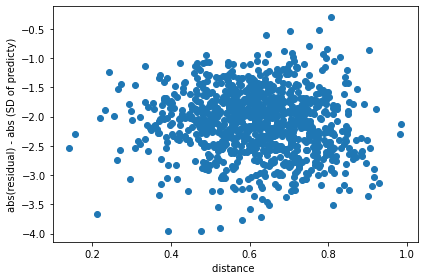

In [ ]:
abs_res_predErr = residual.abs() - sd_series.abs()
_, axs = plt.subplots( tight_layout=True)
axs.scatter(distance, abs_res_predErr)
axs.set_xlabel('distance ')
axs.set_ylabel('abs(residual) - abs (SD of predicty)')

## q=[|Residual| / |Predicted Error|] vs. d=distance;

Text(0, 0.5, 'abs(residual) / abs(SD of predicty)')

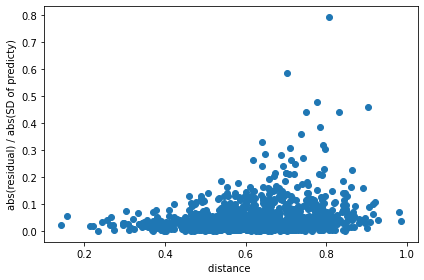

In [30]:
abs_residual_over_abs_sd = residual.abs() / sd_series.abs()
_, axs = plt.subplots( tight_layout=True)
axs.scatter(distance, abs_residual_over_abs_sd)
axs.set_xlabel('distance ')
axs.set_ylabel('abs(residual) / abs(SD of predicty)')

In [31]:
# 

output = pd.DataFrame(IF_pred,columns=['anomaly'])
output['anomaly_score'] = decision_score
output['distance'] = distance
output['abs_residual_over_abs_sd'] = [x[0] for x in abs_residual_over_abs_sd]


output.head()

,anomaly,anomaly_score,distance,abs_residual_over_abs_sd
0,1,0.015130,0.507549,0.036331
1,1,0.009755,0.581790,0.028146
2,-1,-0.002057,0.591617,0.076683
3,1,0.000282,0.497614,0.064406
4,1,0.033118,0.391027,0.021831


In [ ]:
import plotly.express as px
fig = px.scatter(output, x="distance", y="abs_residual_over_abs_sd", color="anomaly_score", size_max=4)
fig.show()
fig = px.scatter(output, x="distance", y="abs_residual_over_abs_sd", color="anomaly")
fig.show()
fig = px.scatter(output, x="distance", y="anomaly_score", color="anomaly")
fig.show()

In [ ]:
fig = px.scatter(output, x="anomaly_score", y="abs_residual_over_abs_sd", color="anomaly")
fig.show()

In [ ]:
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
# predict IF
def f(i):
  IF = IsolationForest(n_estimators=numTree, contamination=i)
  IF.fit(trainX)
  IF_pred = IF.predict(testX)
  IF_pred = pd.DataFrame(IF_pred)
  IF_pred = IF_pred.values
  output['anomaly_score'] = IF.decision_function(testX)
  output['anomaly'] = IF_pred

  fig0= px.scatter(output, x="distance", y="abs_residual_over_sd", color="anomaly")
  fig0.show()
  #fig = px.scatter(output, x="distance", y="abs_residual_over_sd", color="anomaly_score")
  #fig.show()

contam_slider = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=1,
    step=0.01,
    description='contamination',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
  
)

interact(f,i  = contam_slider);

interactive(children=(FloatSlider(value=0.1, description='contamination', max=1.0, step=0.01), Output()), _dom…

In [ ]:
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
# predict IF
def f(i,j):
  global IF_pred, IF2_pred
  # IF #1 using contam i
  IF = IsolationForest(n_estimators=numTree, contamination=i)
  IF.fit(trainX)
  IF_pred = IF.predict(testX)
  IF_pred = pd.DataFrame(IF_pred)
  IF_pred = IF_pred.values
  # IF #2 using contam j
  IF2 = IsolationForest(n_estimators=numTree, contamination=j)
  IF2.fit(trainX)
  IF2_pred = IF2.predict(testX)
  IF2_pred = pd.DataFrame(IF2_pred)
  IF2_pred = IF2_pred.values

  new_pred = []
  for first_model_pred, second_model_pred in zip(IF_pred,IF2_pred):
    if first_model_pred == [-1]:  #if anomaly from first contam rate
      new_pred.append(-1)       # append as anomaly
    elif second_model_pred == [1]: # if not anomaly from second contam rate model,
      new_pred.append(1)       #append as not an anomaly
    else:
     new_pred.append(0)        #else, append as neither
  # output['anomaly_score_i'] = IF.decision_function(testX)
  output['anomaly'] = new_pred
  fig0= px.scatter(output, x="distance", y="abs_residual_over_abs_sd",
                   color="anomaly",color_continuous_scale='Portland')
  fig0.show()
  #fig = px.scatter(output, x="distance", y="abs_residual_over_sd", color="anomaly_score")
  #fig.show()

contam_slider = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=1,
    step=0.01,
    description='c_rate_1',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
  
)

contam_slider2 = widgets.FloatSlider(
    value=0.7,
    min=0,
    max=1,
    step=0.01,
    description='c_rate_2',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
  
)

interact(f,i  = contam_slider, j = contam_slider2);

interactive(children=(FloatSlider(value=0.1, description='c_rate_1', max=1.0, step=0.01), FloatSlider(value=0.…

In [ ]:
new_pred = []
for first_model_pred, second_model_pred in zip(IF_pred,IF2_pred):
  if first_model_pred == [-1]:  #if anomaly from first contam rate
    new_pred.append(-1)       # append as anomaly
  elif second_model_pred == [1]: # if not anomaly from second contam rate model,
    new_pred.append(1)       #append as not an anomaly
  else:
    new_pred.append(0)        #else, append as neither

In [ ]:
pd.DataFrame(new_pred, columns =['anomaly']).value_counts()

anomaly
 0         620
 1         292
-1          88
dtype: int64

In [ ]:
list(new_pred)

[1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 -1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 -1,
 1,
 -1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 -1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 -1,
 0,
 -1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 0,
 1,
 1,
 -1,
 -1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 -1,
 1,
 1,
 1,
 0,
 0,
 -1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 -1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 -1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 -1,
 -1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 -1,
 0,
 1,
 -1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,

# Try lolopy

In [ ]:
from lolopy.learners import RandomForestRegressor

rf = RandomForestRegressor( num_trees= 500, max_depth = 30)
rf.fit(trainX,trainY)
y_pred, y_std = rf.predict(testX, return_std=True)

In [ ]:
# residual / estimates
testy1 = pd.Series(testY)
predy1 = pd.Series(y_pred)
res1 = (testy1 - predy1) / pd.Series(y_std)

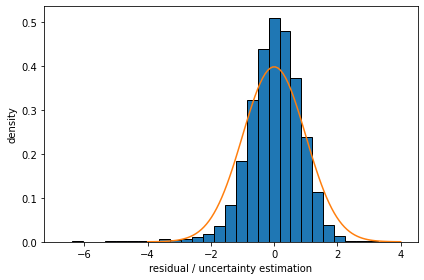

In [ ]:
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)

n_bins = 30
_, axs = plt.subplots( tight_layout=True)
axs.hist( res1, bins = n_bins, edgecolor = 'k', density = True)
axs.plot(x, stats.norm.pdf(x, mu, sigma))
axs.set_xlabel('residual / uncertainty estimation')
axs.set_ylabel('density')
None

In [ ]:
from sklearn.metrics import mean_squared_error
def f_rms(testy, predy):
    return mean_squared_error(testy, predy, squared=False)

# Plot [Res-PredErr] for many test (X*,Y*) pairs vs. distance of X* from the training data {Xt}.  Do for RF first with Euclidean distance.


In [ ]:
# looks like : at 0, then go away.
# residual: res1
# prederr: sd of ensemble of prediction
# for training data 500, average_x0, average_x1, ..., average_x4
# then 10,000 iteration: distance between (avg_x0,x1,x2,,x3,x4) and (x0,x1,..,x4) in test set

In [ ]:
predErr = np.std(predy1)
res_predErr = res1 - predErr
size = 500
res_predErr500 = res_predErr[:size]
# numpy.linalg.norm gives Euclidean distance
distance = []
for i in range(size):
    a = np.array(test_x.iloc[i])
    b = np.array(train_x.iloc[i])
    dist = np.linalg.norm(a-b)
    distance.append(dist)

Text(0, 0.5, 'residual - SD of predicty')

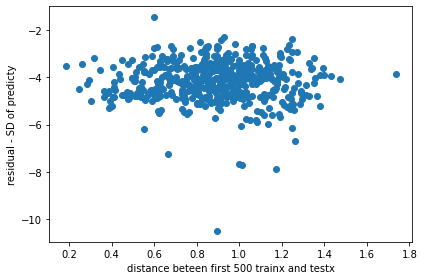

In [ ]:
_, axs = plt.subplots( tight_layout=True)
axs.scatter(distance,res_predErr500)
axs.set_xlabel('distance beteen first 500 trainx and testx')
axs.set_ylabel('residual - SD of predicty')

In [ ]:
# compute average of each feature of training data
x0 = train.loc[:, 'x0']
avg_x0 =  sum(x0) / len(x0)
x1 = train.loc[:, 'x1']
avg_x1 =  sum(x1) / len(x1)
x2 = train.loc[:, 'x2']
avg_x2 =  sum(x2) / len(x2)
x3 = train.loc[:, 'x3']
avg_x3 =  sum(x3) / len(x3)
x4 = train.loc[:, 'x4']
avg_x4 =  sum(x3) / len(x4)
avg_x = np.array([avg_x0, avg_x1, avg_x2, avg_x3, avg_x4])
avg_x

array([0.49628985, 0.50873369, 0.49724807, 0.49281713, 0.49281713])

In [ ]:
distance1 = []
size = 10000
for i in range(size):
    a = avg_x
    b = np.array(test_x.iloc[i])
    dist = np.linalg.norm(a-b)
    distance1.append(dist)

Text(0, 0.5, 'residual - SD of predicty')

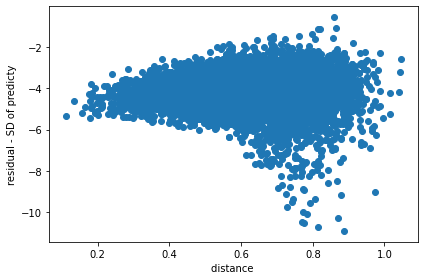

In [ ]:
_, axs = plt.subplots( tight_layout=True)
axs.scatter(distance1, res_predErr)
axs.set_xlabel('distance ')
axs.set_ylabel('residual - SD of predicty')

In [ ]:
from sklearn.metrics import mean_squared_error
def f_rms(testy, predy):
    return mean_squared_error(testy, predy, squared=False)

## Residual vs. distance; Pred Err vs. distance

In [ ]:

# _, axs = plt.subplots( tight_layout=True)
# axs.scatter(distance1, pre_err)
# axs.set_xlabel('distance ')
# axs.set_ylabel('residual - SD of predicty')

In [ ]:

# _, axs = plt.subplots( tight_layout=True)
# axs.scatter(distance1, predErr)
# axs.set_xlabel('distance ')
# axs.set_ylabel('residual - SD of predicty')